In [1]:
import os
os.chdir('./GymGo-master')

In [38]:
import gym
import random
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
from gym_go import state_utils, govars

import matplotlib.pyplot as plt
# import seaborn as sns

from scipy.stats import iqr
import pickle

import sys
sys.path.append(os.getcwd())
import torch
import torch.nn as nn
import torch.optim as optim
import copy

from TDRC.DQRC import DQRC
#from TDRC.TDRC import TDRC

In [39]:
# 1. Structure
# mini-batch to update several states at the same time
# use target network to gain stablility
# replay buffer: iid for SGD optimization
# 2. Add Symmetry trick 
# 3. Add Layer
# 3. Get Value Function

In [50]:
TARGET_REFRESH = 1
ALPHA = 0.0009765
size = 3
sample_size= 4
GAMMA = 0.99
train_episodes = 100000
eval_episodes = 1000

In [51]:
import torch
import numpy as np
import torch.nn.functional as f
from TDRC.utils import getBatchColumns

class TDRC:
    def __init__(self, features, policy_net, target_net, optimizer, params, device=None):
        self.features = features
        self.params = params
        self.device = device
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optimizer

        # regularization parameter
        self.alpha = params['alpha']
        self.epsilon = params['epsilon']
        self.beta = params['beta']

        # secondary weights optimization parameters
        self.beta_1 = params.get('beta_1', 0.99)
        self.beta_2 = params.get('beta_2', 0.999)
        self.eps = params.get('eps', 1e-8)

        # learnable parameters for secondary weights
        self.h = torch.zeros(features, requires_grad=False).to(device)
        # ADAM optimizer parameters for secondary weights
        self.v = torch.zeros(features, requires_grad=False).to(device)
        self.m = torch.zeros(features, requires_grad=False).to(device)
        
    def selectAction(self, x):
        # take a random action about epsilon percent of the time
        if np.random.rand() < self.epsilon:
            a = env.uniform_random_action()
            return a

        # otherwise take a greedy action
        q_s, _ = self.policy_net(x)
        return q_s.argmax().detach().cpu().numpy()

    def updateNetwork(self, samples):
        # organize the mini-batch so that we can request "columns" from the data
        # e.g. we can get all of the actions, or all of the states with a single call
        batch = getBatchColumns(samples)

        # compute V(s) for each sample in mini-batch
        Vs, x = self.policy_net(batch.states)

        # by default V(s') = 0 unless the next states are non-terminal
        Vsp = torch.zeros(batch.size, device=self.device)

        # if we don't have any non-terminal next states, then no need to bootstrap
        if batch.nterm_sp.shape[0] > 0:
            Vsp, _ = self.target_net(batch.nterm_sp)

        # compute the empirical MSBE for this mini-batch and let torch auto-diff to optimize
        # don't worry about detaching the bootstrapping term for semi-gradient TD
        # the target network handles that
        target = batch.rewards + batch.gamma * Vsp.detach()
        td_loss = 0.5 * f.mse_loss(target, Vs)

        # compute E[\delta | x] ~= <h, x>
        with torch.no_grad():
            delta_hat = torch.matmul(x, self.h.t())

        # the gradient correction term is gamma * <h, x> * \nabla_w V(s')
        # to compute this gradient, we use pytorch auto-diff
        correction_loss = torch.mean(batch.gamma * delta_hat * Vsp)

        # make sure we have no gradients left over from previous update
        self.optimizer.zero_grad()
        self.target_net.zero_grad()

        # compute the entire gradient of the network using only the td error
        td_loss.backward()

        # if we have non-terminal states in the mini-batch
        # the compute the correction term using the gradient of the *target network*
        if batch.nterm_sp.shape[0] > 0:
            correction_loss.backward()

        # add the gradients of the target network for the correction term to the gradients for the td error
        for (policy_param, target_param) in zip(self.policy_net.parameters(), self.target_net.parameters()):
            policy_param.grad.add_(target_param.grad)

        # update the *policy network* using the combined gradients
        self.optimizer.step()

        # update the secondary weights using a *fixed* feature representation generated by the policy network
        with torch.no_grad():
            delta = target - Vs
            dh = (delta - delta_hat) * x - self.beta * self.h

            # ADAM optimizer
            # keep a separate set of weights for each action here as well
            self.v = self.beta_2 * self.v + (1 - self.beta_2) * (dh**2)
            self.m = self.beta_1 * self.m + (1 - self.beta_1) * dh

            self.h = self.h + self.alpha * self.m / (torch.sqrt(self.v) + self.eps)

In [52]:
# build the structure of our neural network
# we need to output both the last layer and the second to last layer
# TODO: add layer and nodes
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear((size**2)*2, sample_size),
            nn.ReLU(),
            nn.Linear(sample_size, sample_size),
            nn.ReLU(),
        )

        self.output = nn.Linear(sample_size, size**2)

    def forward(self, x):
        features = self.model(x)
        outputs = self.output(features)
        return outputs, features

# build the target and policy networks
# the target net is the same as the policy net, but with the weights occupying different memory

policy_network = Network()
target_network = copy.deepcopy(policy_network)
optimizer = optim.Adam(policy_network.parameters(), lr = ALPHA, betas=(0.9, 0.999))

    
# construct our TDRC agent
agent = DQRC(sample_size, size**2, policy_network, target_network, optimizer, {
    'alpha': ALPHA,
    'beta': 1.0,
    'epsilon': 0.1,
})



# much much faster than np.random.choice
def choice(arr, size=1):
    idxs = np.random.permutation(len(arr))
    return [arr[i] for i in idxs[:size]]

# a very simple circular replay buffer

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.location = 0
        self.buffer = []

        
        
    def __len__(self):
        return len(self.buffer)

    def add(self, args):
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(args)
        else:
            self.buffer[self.location] = args
        self.location = (self.location + 1) % self.buffer_size

    def sample(self, batch_size):
        return choice(self.buffer, batch_size)



In [53]:
#env = gym.make('gym_go:go-v0', size=size, reward_method = 'real')
#env.reset()
# ---------------------
# Start the experiments
# ---------------------
buffer = ReplayBuffer(4000)
# current env
#s = env.state()
# current state
#x = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(size**2)), axis=None), dtype=torch.float32).unsqueeze(0)

rewards = 0
step = 0
for i in range(train_episodes):
    env = gym.make('gym_go:go-v0', size=size, reward_method = "real")
    env.reset()
    done = False
    while not done:
        
        s = env.state()
        x = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(size**2)), axis=None), dtype=torch.float32).unsqueeze(0)

        
        step += 1
        
        if step % TARGET_REFRESH == 0:
            target_network.load_state_dict(policy_network.state_dict())
        
        action = agent.selectAction(x)
        
        #q_s, _ = agent.policy_net(x)
        #q_s = q_s.detach().cpu().numpy()   
        #q_s = [float('-inf') if s[3].reshape(size**2)[i] == 1 else q_s[0][i] for i in range(size**2)]
        #action = np.array(q_s).argmax()
        
        #print(action)
        
        valid = np.nonzero(env.valid_moves())[0]
        
        if action not in valid:
            action_index = env.uniform_random_action()
        elif isinstance(action, int):
            action_index = action
        else:
            action_index = action.item()
            
        #print(action_index)
            
        sp, reward, done, info = env.step(action_index)
        
        
        xp = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(size**2)), axis=None), dtype=torch.float32).unsqueeze(0)
        
        if done:
            xp = None
            
        #print(xp)

        a = torch.tensor(action, dtype=torch.int64)
        r = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)

        # use a state-based gamma where gamma = 0.99 of all states
        # and gamma = 0 for the terminal state
        gamma = torch.tensor(0 if done else GAMMA)
        buffer.add((x, a, r, xp, gamma))

        
        # once the buffer has enough samples to start updating
        # then start updating
        if step > sample_size:
            samples = buffer.sample(sample_size)
            agent.updateNetwork(samples)
        
        s = sp
        x = xp
        

    if reward == 1:
        rewards += 1
        

        
rewards_nn = 0
for i in range(1000):
    env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")
    env.reset()
    done = False

    while not done:
        action = agent.selectAction(x)
        valid = np.nonzero(env.valid_moves())[0]

        if action not in valid:
            action_index = env.uniform_random_action()
        elif isinstance(action, int):
            action_index = action
        else:
            action_index = action.item()


        state, reward, done, info = td.env.step(action_index)



        if done:
            break
        # white    
        action = env.uniform_random_action()
        state, reward, done, info = env.step(action)

    #print(reward)
    if reward == 1:
        rewards_nn += 1


NameError: name 'eval_episodes' is not defined

In [56]:
rewards_nn = 0
for i in range(1000):
    env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")
    env.reset()
    done = False

    while not done:
        s = env.state()
        x = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(size**2)), axis=None), dtype=torch.float32).unsqueeze(0)


        action = agent.selectAction(x)
        valid = np.nonzero(env.valid_moves())[0]

        if action not in valid:
            action_index = env.uniform_random_action()
        elif isinstance(action, int):
            action_index = action
        else:
            action_index = action.item()


        state, reward, done, info = env.step(action_index)



        if done:
            break
        # white    
        action = env.uniform_random_action()
        state, reward, done, info = env.step(action)

    #print(reward)
    if reward == 1:
        rewards_nn += 1

In [57]:
rewards_nn

519

In [ ]:
# TD training

start_time = time.time()
rewards_td = dict()
for j in train_episodes:
    td = Learn(size = size)
    td.sarsa_td(n_episodes=j)

    reward_td = 0
    for i in range(eval_episodes): 
            td.env = gym.make('gym_go:go-v0', size=size,  reward_method = "real")
            td.env.reset()
            done = False

            while not done:
                states = all_state2num(td.env.state(),size)
                action_index = td.apply_policy(states, 0.1)
                state, reward, done, info = td.env.step(action_index)



                if done:
                    break
                # white    
                action = td.env.uniform_random_action()
                state, reward, done, info = td.env.step(action)
                
            #print(reward)
            if reward == 1:
                reward_td = reward_td + 1
    rewards_td[j] = reward_td
    print(reward_td)


        

        
print("--- %s seconds ---" % (time.time() - start_time))



(0.0, 0.5)

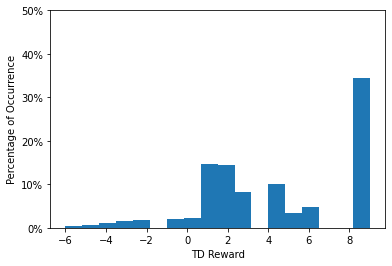

In [79]:
plt.hist(episode_reward, weights=np.ones(len(episode_reward)) / len(episode_reward), bins = 18)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('TD Reward')
plt.ylim([0, 0.5])

(0.0, 0.5)

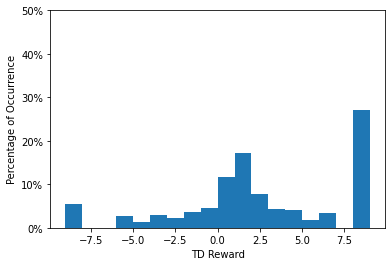

In [80]:
from matplotlib.ticker import PercentFormatter
plt.hist(episode_reward_r, weights=np.ones(len(episode_reward_r)) / len(episode_reward_r), bins = 18)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('TD Reward')
plt.ylim([0, 0.5])